In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [4]:
# Note that this reads "Dec-62" as 2062-12-01. By default pd.to_datetime assumes 21st century up to 2068.
# I tried defining a custom date parser, but that slowed read_csv down considerably.
# We will fix this later.

parse_dates = ["issue_d", "earliest_cr_line", "last_pymnt_d", "next_pymnt_d", "last_credit_pull_d"]

df = pd.read_csv("/Users/partwalk/Projects/Upgrad/upgrad/Exploratory Data Analysis/loan.csv", date_format="%b-%y", parse_dates=parse_dates)

In [5]:
# Drop the columns with only NaN values

for x in df.columns:
    if df[x].isnull().all():
        df.drop(x, axis=1, inplace=True)

In [6]:
# Checking which columns have a single value, and what the value is

for x in df.columns:
    if len(df[x].unique()) <= 2:
        print(x, df[x].unique())

term [' 36 months' ' 60 months']
pymnt_plan ['n']
initial_list_status ['f']
collections_12_mths_ex_med [ 0. nan]
policy_code [1]
application_type ['INDIVIDUAL']
acc_now_delinq [0]
chargeoff_within_12_mths [ 0. nan]
delinq_amnt [0]
tax_liens [ 0. nan]


In [7]:
# Deleting the above columns with a single value

for x in df.columns:
    if len(df[x].unique()) == 1:
        df.drop(x, axis=1, inplace=True)

In [8]:
# Dropping since these 3 columns only have values of 0 or NaN. next_pymnt_d has values either 'Jun-16' or 'Jul-16'
df.drop(['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens', 'next_pymnt_d'], axis=1, inplace=True)

In [9]:
# Which columns have a majority null values

for x in df.columns:
    percent_null = (df[x].isnull().sum() * 100) / df.shape[0]
    if percent_null > 50:
        print(x, percent_null)

mths_since_last_delinq 64.66248709620565
mths_since_last_record 92.98537150338646


In [10]:
# Change int_rate and revol_util, which are percentages, to float

df['int_rate'] = df['int_rate'].str.strip(' %').astype('float') / 100
df['revol_util'] = df['revol_util'].str.strip(' %').astype('float') / 100

In [11]:
# Change 'term' column to int64

if all(df['term'].str.endswith('months')):
    df['term'] = pd.to_numeric(df['term'].str.strip(' months'))

In [12]:
# Cleaning the description column
# Removing the trailing <br> tag and "Borrower added... >"

df['desc'] = df['desc'].str.replace('<br>','').str.replace('.*> ','', regex=True).str.strip()

In [13]:
# Change employee_length to float

df['emp_length'] = df['emp_length'].str.strip(' years')
df['emp_length'] = df['emp_length'].str.strip(' year')
df['emp_length'] = df['emp_length'].str.strip('+')
df['emp_length'] = df['emp_length'].apply(lambda x: 0 if x == '< 1' else x)
df['emp_length'] = pd.to_numeric(df['emp_length'])

In [14]:
# Fixing dates
# To check if condition > 2016 gives the correct subset
mask = df['earliest_cr_line'].dt.year > 2016
df[mask]['earliest_cr_line'].describe()

count                     90
mean     2065-05-05 03:44:00
min      2046-01-01 00:00:00
25%      2063-12-31 12:00:00
50%      2066-03-16 12:00:00
75%      2067-10-24 06:00:00
max      2068-12-01 00:00:00
Name: earliest_cr_line, dtype: object

In [15]:
# For dates beyond 2016, offset them by 100 years
df.loc[mask, 'earliest_cr_line'] = df.loc[mask, 'earliest_cr_line'] - pd.DateOffset(years=100)

In [16]:
def barchart(series, title):
    plt.figure(figsize=(10, 10))
    series.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title('Proportion of Delinquent Loans Segmented by '+title, fontsize=14)
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Proportion Delinquent Loans', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()

    plt.savefig('./loan_per_'+title.lower().replace(' ','_')+'.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

In [17]:
df.groupby('home_ownership')['loan_status'].value_counts(normalize=True, dropna=True)

home_ownership  loan_status
MORTGAGE        Fully Paid     0.832097
                Charged Off    0.131774
                Current        0.036129
NONE            Fully Paid     1.000000
OTHER           Fully Paid     0.816327
                Charged Off    0.183673
OWN             Fully Paid     0.827992
                Charged Off    0.144866
                Current        0.027142
RENT            Fully Paid     0.827610
                Charged Off    0.150220
                Current        0.022170
Name: proportion, dtype: float64

Per above, 18.3% of people who listed 'OTHER' under home ownership defaulted their loan.\
Comparitively, of the people who rented/mortgaged/owned homes, the default rate was at most 15%.\
The 'OTHER' category can be seen as a risk factor for delinquency.


In [18]:
c = df.groupby('purpose')['loan_status'].value_counts(normalize=True, dropna=True)
c.xs('Charged Off', level=1).sort_values(ascending=False)

purpose
small_business        0.259847
renewable_energy      0.184466
educational           0.172308
other                 0.158527
moving                0.157804
house                 0.154856
medical               0.152958
debt_consolidation    0.148436
vacation              0.139108
home_improvement      0.116599
credit_card           0.105653
car                   0.103292
major_purchase        0.101509
wedding               0.101373
Name: proportion, dtype: float64

In [18]:
c.xs('Fully Paid', level=1).sort_values(ascending=False)

purpose
major_purchase        0.881573
wedding               0.876452
credit_card           0.874269
car                   0.864429
home_improvement      0.849462
vacation              0.845144
moving                0.830189
medical               0.829726
educational           0.827692
debt_consolidation    0.820128
other                 0.809416
house                 0.808399
renewable_energy      0.805825
small_business        0.699672
Name: proportion, dtype: float64

26% of all loans taken for Small Businesses end in default.\
Renewable Energy, Educational, Other, Moving, House, and Medical loans all have a default rate above 15%.

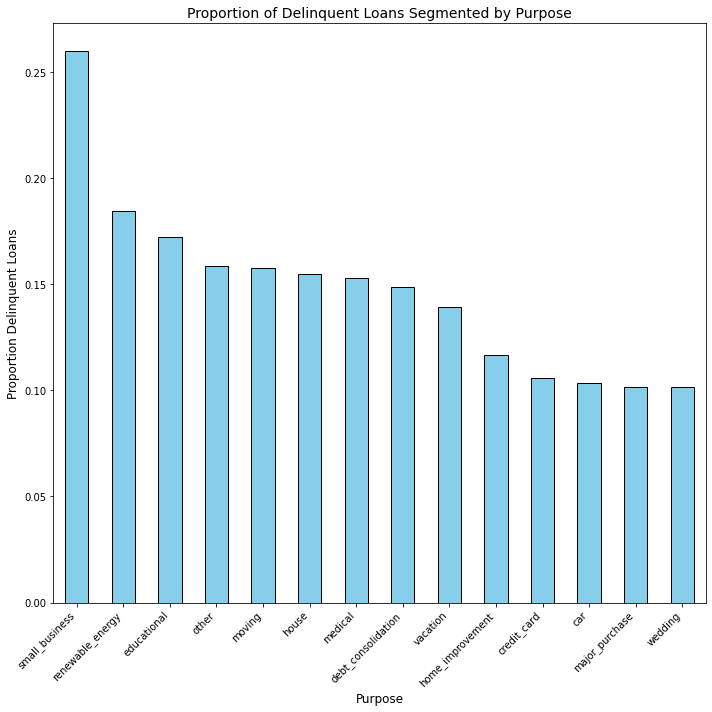

In [19]:
barchart(c.xs('Charged Off', level=1).sort_values(ascending=False), "Purpose")

In [20]:
c = df.groupby('verification_status')['loan_status'].value_counts(normalize=True, dropna=True)
c

verification_status  loan_status
Not Verified         Fully Paid     0.859996
                     Charged Off    0.126588
                     Current        0.013415
Source Verified      Fully Paid     0.825373
                     Charged Off    0.143587
                     Current        0.031040
Verified             Fully Paid     0.792802
                     Charged Off    0.160122
                     Current        0.047076
Name: proportion, dtype: float64

Both Verified and Source Verified have a higher default rate than Not Verified status. This could be because the lender places too much of an emphasis on verification,
leading them to take a greater risk on borrowers with verified incomes. This risk is not justified.\
One way of reducing defaults would be to decrease the importance of verification in their decision matrix.

In [72]:
def barchartv2(multi, index):
    df = multi.reset_index(name='proportion')
    
    df_pivot = df.pivot(index=index, columns='loan_status', values='proportion')
 
    df_pivot.plot(kind='bar', stacked=False, figsize=(10, 10), color=['darkblue', 'violet', 'skyblue'])

    x_title = index.replace('_',' ').title()
    plt.title('Proportion of Loan Status by '+x_title, fontsize=14)
    plt.xlabel(x_title, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Loan Status')
    
    plt.tight_layout()
    
    plt.savefig('./loan_per_'+index+'.png', dpi=300, bbox_inches='tight', facecolor='white')

    plt.show()


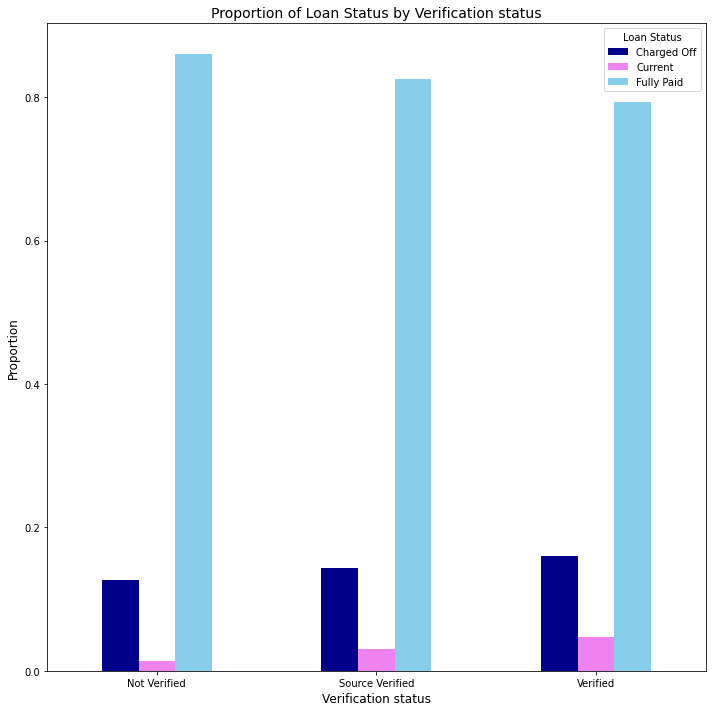

In [40]:
barchartv2(c, 'verification_status')

In [41]:
t = df.groupby('term')['loan_status'].value_counts(normalize=True, dropna=True)
t

term  loan_status
36    Fully Paid     0.889091
      Charged Off    0.110909
60    Fully Paid     0.666698
      Charged Off    0.225967
      Current        0.107335
Name: proportion, dtype: float64

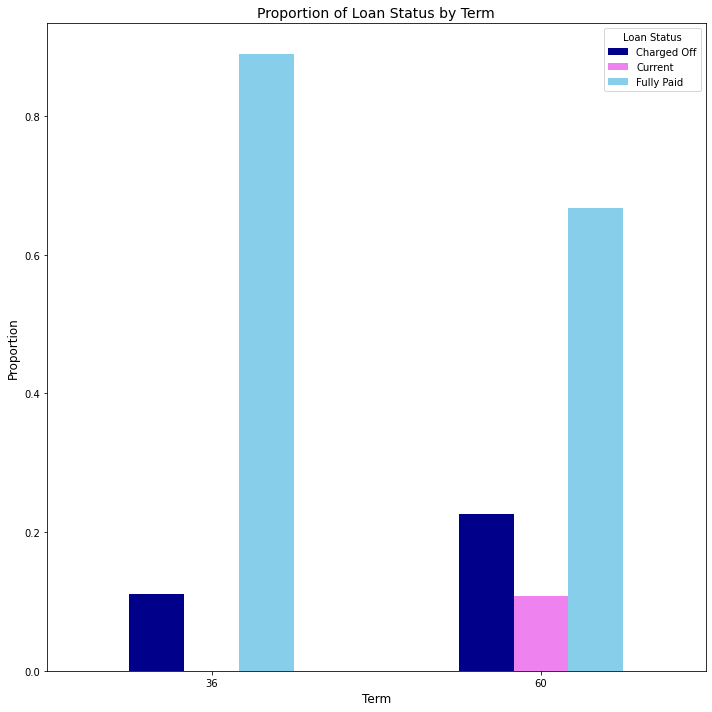

In [42]:
barchartv2(t, "term")

Loans with a 60 month term were twice as likely to end in default as loans with 36 month terms.

In [43]:
g = df.groupby('grade')['loan_status'].value_counts(normalize=True, dropna=True)
gr = g.xs('Charged Off', level=1).sort_values(ascending=False)
gr

grade
G    0.319620
F    0.304099
E    0.251583
D    0.210665
C    0.166337
B    0.118552
A    0.059693
Name: proportion, dtype: float64

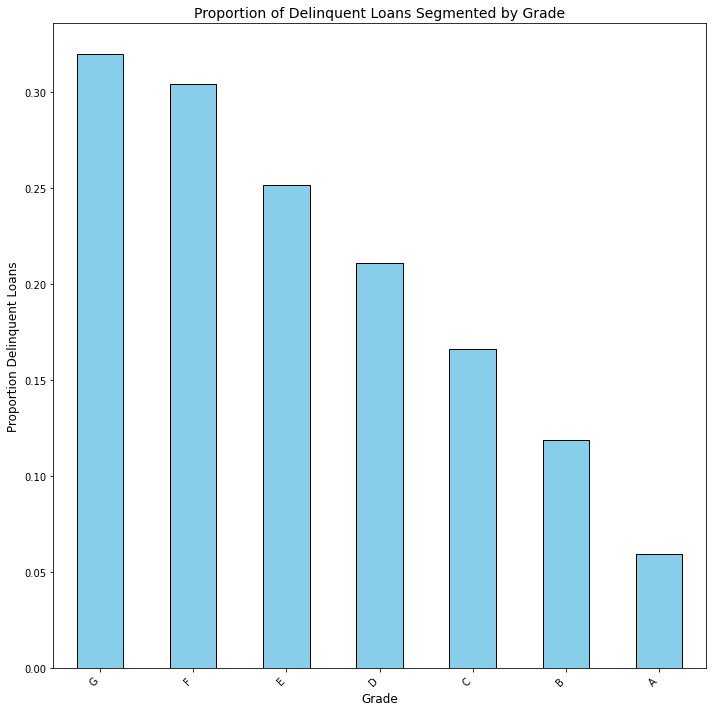

In [44]:
barchart(gr, "Grade")

In [21]:
# Checking if purpose and grade are correlated
df.groupby('purpose')['grade'].value_counts(normalize=True, dropna=True).xs('small_business', level=0).sort_values(ascending=False)

grade
B    0.260394
C    0.194201
A    0.190372
D    0.164661
E    0.111597
F    0.053063
G    0.025711
Name: proportion, dtype: float64

In [47]:
# Convert loan_status to a binary: 1 for default, 0 for no
defaulted = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
# Convert grades to its numeric value
grade_num = df['grade'].apply(lambda x: string.ascii_uppercase.index(x))
grade_num.corr(defaulted)

np.float64(0.1904093598280218)

As the grade decreases in quality, the rate of default shoots up from 5% of Grade A loans to 32% of Grade G loans.
The correlation coefficient of grade vs loan_status is 0.19, which is higher than term and revol_util.
Grade is an extremely strong predictor of delinquency.

In [45]:
sgr = df.groupby('sub_grade')['loan_status'].value_counts(normalize=True, dropna=True).xs('Charged Off', level=1).sort_values(ascending=False)
sgr

sub_grade
F5    0.457627
G3    0.395833
G2    0.358974
G5    0.333333
F4    0.315476
G1    0.298077
F2    0.281124
E4    0.277533
F1    0.276596
F3    0.275676
E5    0.262019
E1    0.259502
E2    0.248476
D5    0.239130
G4    0.232143
D4    0.219164
D3    0.218244
E3    0.215190
D2    0.201039
D1    0.179377
C3    0.176586
C5    0.175379
C4    0.171521
C2    0.159622
C1    0.157303
B5    0.131657
B4    0.130971
B3    0.116901
B2    0.110841
B1    0.093443
A5    0.079139
A4    0.061677
A3    0.056906
A2    0.049072
A1    0.026339
Name: proportion, dtype: float64

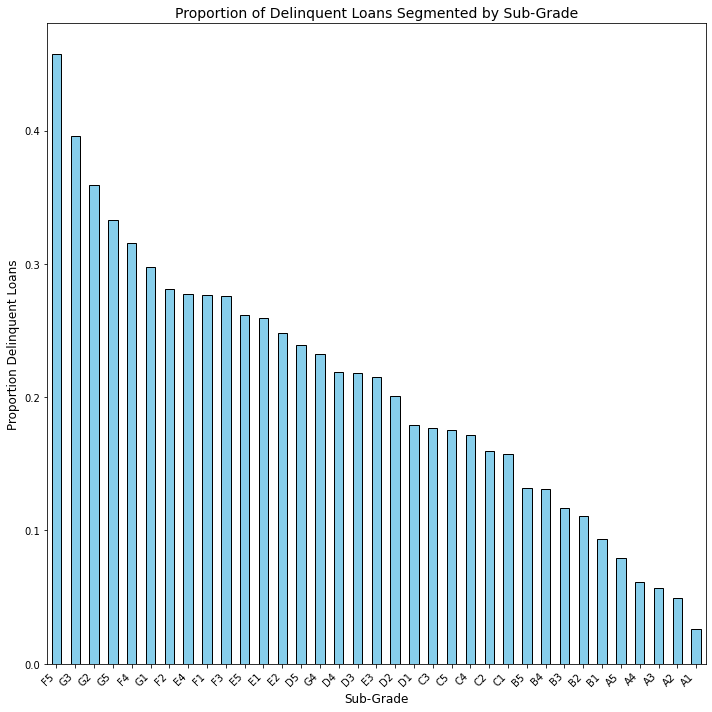

In [46]:
barchart(sgr, "Sub-Grade")

In [48]:
# Finding the correlation between loan_status and all variables
arr = []
for i in df.columns:
    try:
        arr.append((df[i].corr(defaulted), i))
    except:
        continue
sorted(arr)

[(np.float64(-0.3350189558357645), 'total_rec_prncp'),
 (np.float64(-0.23884351067418763), 'total_pymnt'),
 (np.float64(-0.23623247297689037), 'total_pymnt_inv'),
 (np.float64(-0.2149492862554395), 'last_pymnt_amnt'),
 (np.float64(-0.12513224463121259), 'last_pymnt_d'),
 (np.float64(-0.0554760435362905), 'out_prncp'),
 (np.float64(-0.055417349464572344), 'out_prncp_inv'),
 (np.float64(-0.04166180205780614), 'annual_inc'),
 (np.float64(-0.03459363351344248), 'last_credit_pull_d'),
 (np.float64(-0.02356265946099974), 'total_acc'),
 (np.float64(-0.010780379617828137), 'total_rec_int'),
 (np.float64(-0.010741653768281402), 'open_acc'),
 (np.float64(0.0033688357297216513), 'revol_bal'),
 (np.float64(0.004941107969798992), 'mths_since_last_delinq'),
 (np.float64(0.012159760102357265), 'emp_length'),
 (np.float64(0.019779606986994408), 'issue_d'),
 (np.float64(0.019904373876979374), 'delinq_2yrs'),
 (np.float64(0.022197890281549684), 'earliest_cr_line'),
 (np.float64(0.02258872906287438), 'in

We expect correlations to be small, because correlation assumes both variables are continuous and normal, but here one variable is binary.\
Ignoring the confounders and non-predictive variables such as total_pymnt and recoveries,  annual income is slightly negatively correlated, implying that higher income is associated with lesser delinquency.\
On the other hand, term is positively correlated, implying that borrowers who opt for longer terms are more likely to default.\
The utilization rate revol_util is also positively correlated, implying that those who use more credit, and thus are more dependent on it, are more likely to default.

In [83]:
def rankfreq(cname):
    defaulters = df[df['loan_status'] == 'Charged Off']
    fully_paid = df[df['loan_status'] == 'Fully Paid']
    freq = defaulters[cname].value_counts()

    defstate = freq.reset_index()
    defstate.columns = [cname, 'frequency']
    defstate['rank'] = defstate['frequency'].rank(method='first', ascending=False)

    freq = fully_paid[cname].value_counts()

    paidstate = freq.reset_index()
    paidstate.columns = [cname, 'frequency']
    paidstate['rank'] = paidstate['frequency'].rank(method='first', ascending=False)

    return defstate.merge(paidstate, on=cname, how='outer', suffixes=('_def', '_paid')).sort_values('rank_def').head(10)

In [50]:
def rank_freq_graph(df, column):
    plt.figure(figsize=(10, 10))

    plt.plot(df[column], df['rank_def'], label='Default Rank', color='skyblue', marker='o')

    plt.plot(df[column], df['rank_paid'], label='Paid Rank', color='darkblue', marker='o')

    title = column.replace('_', " ").capitalize()
    plt.title('Rank Frequency Comparison by '+title, fontsize=14)
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Rank', fontsize=12)
    plt.xticks(df[column], rotation=45)
    plt.yticks(range(1, 11))

    plt.legend(loc='lower left', fontsize=10)

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.gca().invert_yaxis()

    plt.savefig('./rank_freq_'+column+'.png', dpi=300, bbox_inches='tight', facecolor='white')

    plt.show()

In [84]:
s = rankfreq('addr_state')
s

,addr_state,frequency_def,rank_def,frequency_paid,rank_paid
4,CA,1125.0,1.0,5824,1.0
9,FL,504.0,2.0,2277,4.0
33,NY,495.0,3.0,3203,2.0
42,TX,316.0,4.0,2343,3.0
30,NJ,278.0,5.0,1512,5.0
10,GA,215.0,6.0,1144,9.0
14,IL,197.0,7.0,1281,7.0
37,PA,180.0,8.0,1288,6.0
44,VA,177.0,9.0,1192,8.0
20,MD,162.0,10.0,861,12.0


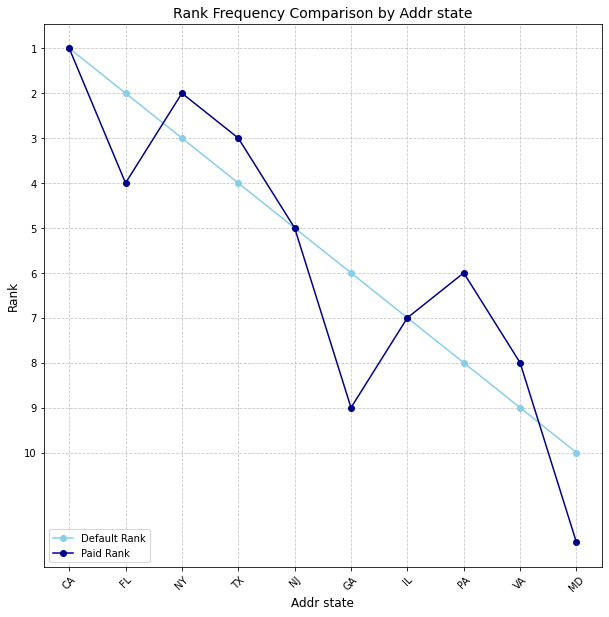

In [52]:
rank_freq_graph(s, 'addr_state')

California is rank 1 among defaulters' state, but it's also the highest among the non-defaulters. This is probably because it has the highest population.\
The top 5 states are all in the top 10 most populated states in the US. No great delta between the two ranks, either.

We could look at lower ranked states, but that has the problem of fewer sample size. We don't want to draw strong conclusions based on small sample size when it comes to states, since writing off entire states could lead to major loss of business.


In [53]:
z = rankfreq('zip_code')
z

,zip_code,frequency_def,rank_def,frequency_paid,rank_paid
773,945xx,80.0,1.0,451.0,2.0
748,917xx,71.0,2.0,269.0,14.0
74,100xx,70.0,3.0,513.0,1.0
298,331xx,70.0,4.0,267.0,15.0
757,926xx,67.0,5.0,299.0,11.0
86,112xx,65.0,6.0,437.0,4.0
50,070xx,65.0,7.0,390.0,5.0
727,891xx,64.0,8.0,178.0,33.0
733,900xx,64.0,9.0,382.0,6.0
268,300xx,52.0,10.0,331.0,8.0


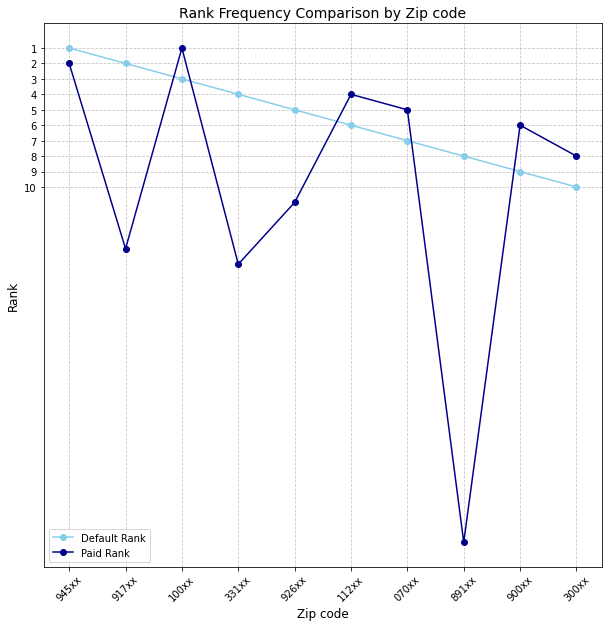

In [54]:
rank_freq_graph(z, 'zip_code')

Zipcodes has the same problem as states; the highest ranks would all bias toward those areas with greater population.\
But we can look at the delta between the two ranks.

Zipcodes beginning with 917, 331, 926 and especially 891 contain a higher proportion of defaulters, compared to other zipcodes like 945 and 100.\
These zipcodes have a far greater frequency amongst deliquents, as shown by the difference in rank_def and rank_paid.

We don't look at ranks below 10 for similar reasons as given for states.

In [85]:
df.groupby('delinq_2yrs')['loan_status'].value_counts(dropna=True).xs('Charged Off', level=1).sort_values(ascending=False)

delinq_2yrs
0    4936
1     507
2     130
3      35
4      13
5       3
6       1
7       1
8       1
Name: count, dtype: int64

In [86]:
df.groupby('delinq_2yrs')['loan_status'].value_counts(normalize=True, dropna=True).xs('Charged Off', level=1).sort_values(ascending=False)

delinq_2yrs
8    0.500000
7    0.250000
4    0.209677
2    0.189229
3    0.159091
1    0.153497
0    0.139415
5    0.136364
6    0.100000
Name: proportion, dtype: float64

Data is too sparse to tell us much.

In [56]:
def boxplt(cname, ylabel, log=False):
    defaulters = df[df['loan_status'] == 'Charged Off']
    fully_paid = df[df['loan_status'] == 'Fully Paid']
    current = df[df['loan_status'] == 'Current']
    data = [defaulters[defaulters[cname].notna()][cname], current[current[cname].notna()][cname], fully_paid[fully_paid[cname].notna()][cname]]
    plt.figure(figsize=(10, 10))
    plt.boxplot(data, tick_labels=['Charged Off', 'Current', 'Fully Paid'])
    plt.title(ylabel + ' Segmented by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(ylabel)
    if log:
        plt.yscale('log')
    plt.savefig('./'+cname+'_boxplot.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

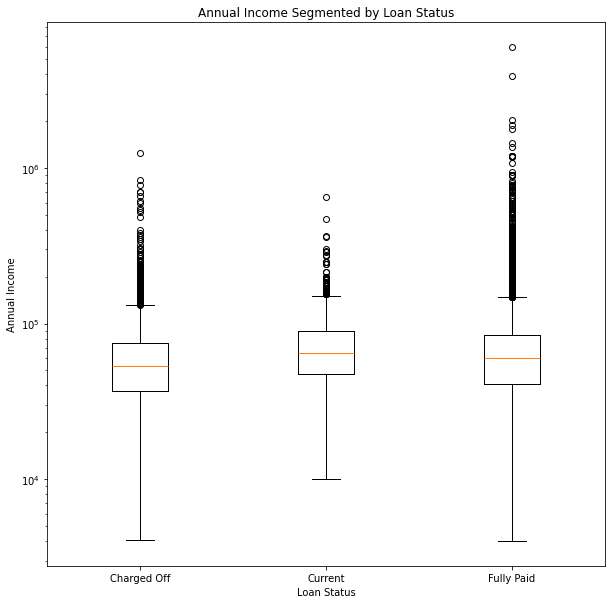

In [59]:
boxplt('annual_inc', 'Annual Income', True)

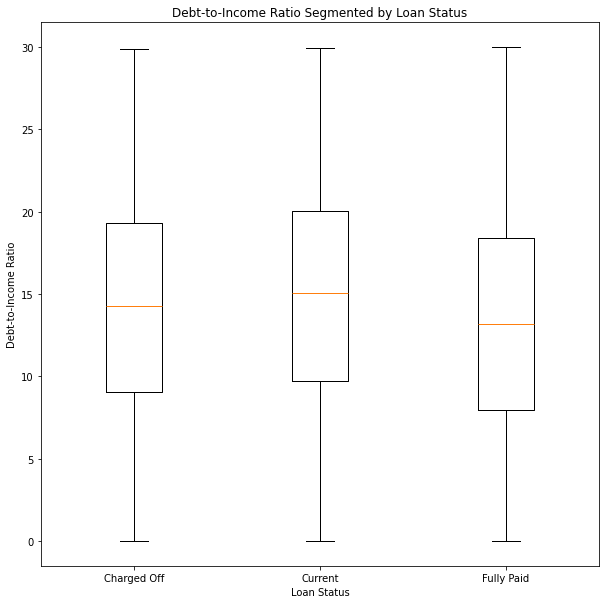

In [60]:
boxplt('dti', 'Debt-to-Income Ratio')

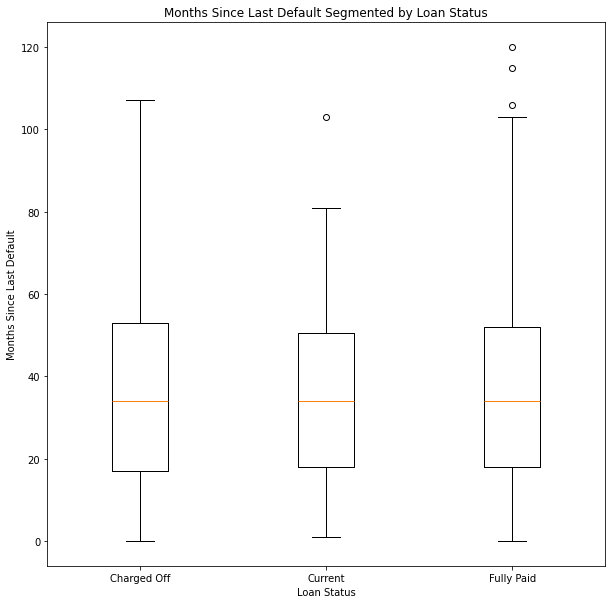

In [61]:
boxplt('mths_since_last_delinq', 'Months Since Last Default')

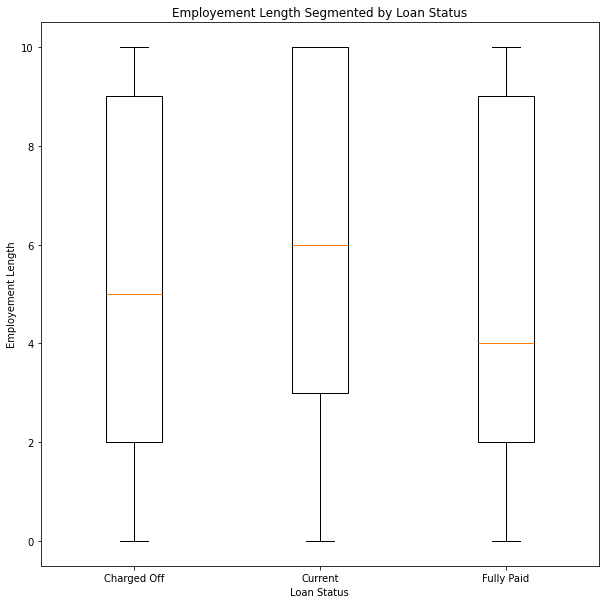

In [62]:
boxplt('emp_length', "Employement Length")

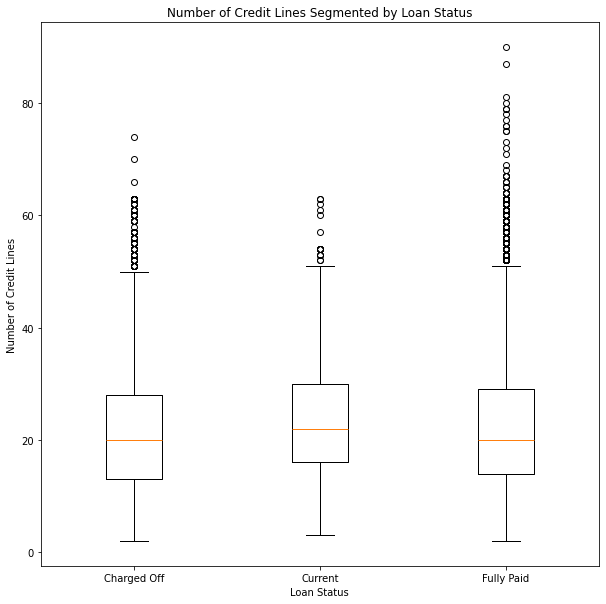

In [63]:
boxplt('total_acc', 'Number of Credit Lines')

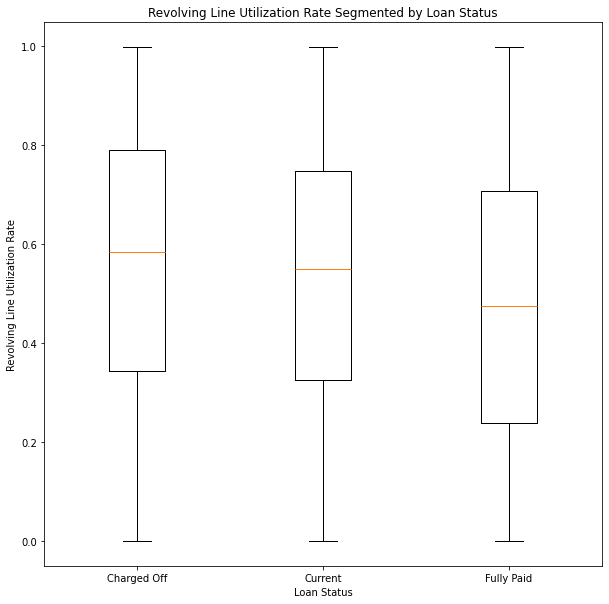

In [57]:
boxplt('revol_util', 'Revolving Line Utilization Rate')

There doesn't seem to be a lot of difference between the annual incomes of people who paid off their loans and those who defaulted. Both cohorts have similar levels of low income. The median is slightly higher for the fully paid cohort, but not enought to be significant. Both have similar first and third quartiles. There's a lot more diversity in the range of incomes among both groups. In contrast, the group paying off open loans on time has a smaller range of incomes. The 'Fully Paid' group has, at the higher end, far greater income than the other two groups, which is as expected. High-income people would be most capable of paying off loans.

The DTI boxplot segmented by Loan Status is similar. The quartiles for defaulters is higher than for "Fully Paid", but lower than "Current". It's hard to draw a strong conclusion from this.

Employee Length, Months Since Last Default, and Total Number of Credit Lines have similarly weak evidence.

The Revolving Line Utilization Rate (RLUR) is significantly higher for deliquient borrowers than for other groups. While the minima and maxima are similar for all groups, all three quartiles are higher for deliquients compared to the other two groups.


In [64]:
# Creating new metrics: the month and quarter of issue date

df['issue_month'] = df['issue_d'].dt.month
df['issue_quarter'] = df['issue_d'].dt.quarter

In [69]:
# Delinquency by issue month
m = df.groupby('issue_month')['loan_status'].value_counts(normalize=True, dropna=True)
m.xs('Charged Off', level=1).sort_values(ascending=False)

issue_month
5     0.155385
12    0.152944
9     0.149945
10    0.147433
6     0.147301
11    0.143509
7     0.137802
1     0.134931
8     0.133030
4     0.130558
3     0.128900
2     0.122986
Name: proportion, dtype: float64

In [70]:
# Fully Paid by issue month

m.xs('Fully Paid', level=1).sort_values(ascending=False)

issue_month
2     0.877014
3     0.870728
4     0.868384
1     0.865069
8     0.830017
7     0.826237
6     0.822507
5     0.817939
11    0.817855
9     0.808936
10    0.808592
12    0.797880
Name: proportion, dtype: float64

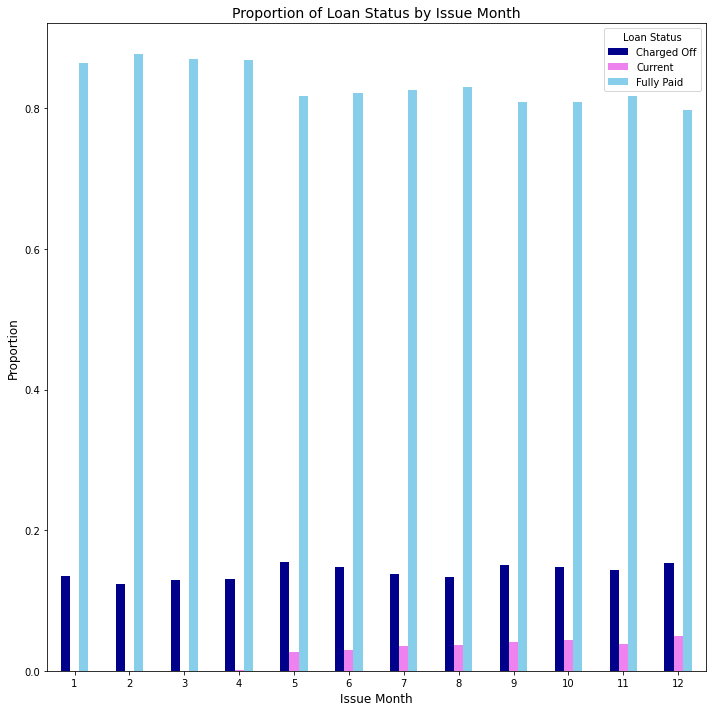

In [73]:
barchartv2(m, 'issue_month')

The rates of both 'Charged Off' and 'Fully Paid' grouped by month of loan issue seem to be fairly similar.\
Not a lot of variation between the rates of default among bad loans. Only around 3%.\
Interestingly, February had both the highest rate of fully paid loans, as well as lowest rate of defaulted loans.\
December was opposite: highest rate of default loans, lowest rate of fully paid loans.\
The lack of variation in the data means this might be a co-incidence.\
We can look at the purpose of the loans to see if the type of loans opened in these months are different.

In [67]:
# Purpose of loans issued in February
df.groupby('issue_month')['purpose'].value_counts(normalize=True, dropna=True).xs(2, level=0).sort_values(ascending=False)

purpose
debt_consolidation    0.489822
credit_card           0.134012
other                 0.094996
small_business        0.055980
home_improvement      0.054283
major_purchase        0.050891
car                   0.044953
wedding               0.022477
medical               0.014419
educational           0.013147
house                 0.009754
moving                0.007634
vacation              0.006785
renewable_energy      0.000848
Name: proportion, dtype: float64

In [68]:
# Purpose of loans taken issued in December
df.groupby('issue_month')['purpose'].value_counts(normalize=True, dropna=True).xs(12, level=0).sort_values(ascending=False)

purpose
debt_consolidation    0.492669
credit_card           0.183848
other                 0.088653
home_improvement      0.057749
small_business        0.043312
major_purchase        0.038123
car                   0.027972
wedding               0.017595
medical               0.014663
moving                0.010828
vacation              0.009249
house                 0.008572
educational           0.005188
renewable_energy      0.001579
Name: proportion, dtype: float64

In both Feb and Dec, nearly half the loans were taken for consolidating debt. The other purposes are similarly ordered.\
So the initial result may have been a co-incidence. We'd have to talk to the lender to see if they have further insight here.

In [74]:
df.groupby('issue_quarter')['loan_status'].value_counts(normalize=True, dropna=True)

issue_quarter  loan_status
1              Fully Paid     0.870911
               Charged Off    0.128954
               Current        0.000135
2              Fully Paid     0.835272
               Charged Off    0.144754
               Current        0.019974
3              Fully Paid     0.821556
               Charged Off    0.140387
               Current        0.038057
4              Fully Paid     0.807883
               Charged Off    0.148077
               Current        0.044040
Name: proportion, dtype: float64

In [75]:
df.groupby('issue_quarter')['purpose'].value_counts(normalize=True, dropna=True)

issue_quarter  purpose           
1              debt_consolidation    0.473415
               credit_card           0.132454
               other                 0.095168
               home_improvement      0.061920
               major_purchase        0.055593
               small_business        0.054381
               car                   0.045901
               wedding               0.024633
               medical               0.016422
               house                 0.011038
               educational           0.010230
               moving                0.009692
               vacation              0.007538
               renewable_energy      0.001615
2              debt_consolidation    0.434592
               credit_card           0.113477
               other                 0.112709
               home_improvement      0.094491
               major_purchase        0.066506
               car                   0.045435
               small_business        0.040606


When grouping by quarter, there isn't a lot of variation in the data, though the first quarter has the fewest delinquent loans, which reinforces what we saw for February.
When looking at purposes, we see debt_consolidation again at the top, and others follow the same relative order.\
All in all, not very enlightening.

In [76]:
df['desclen'] = df['desc'].str.replace(' ','').str.len().fillna(0)

In [77]:
df.groupby('loan_status')['desclen'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5627.0,156.347965,252.356000,0.0,0.0,71.0,203.5,2977.0
Current,1140.0,114.933333,182.922104,0.0,0.0,49.0,163.0,2046.0
Fully Paid,32950.0,166.450440,254.505761,0.0,0.0,76.0,226.0,3304.0


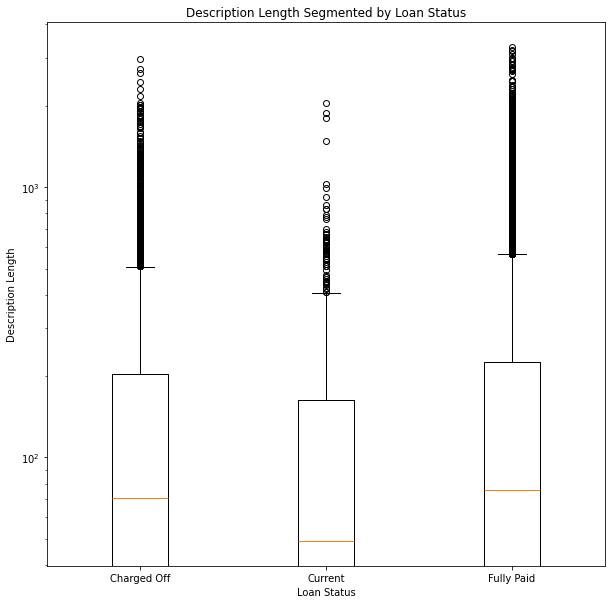

In [78]:
boxplt('desclen', "Description Length", True)

In [87]:
df['desclen'].corr(defaulted)

np.float64(-0.011569107610235408)

Fully Paid and Charged Off have similar figures for all quartiles.
There doesn't seem to be a strong relationship between description length and loan status.

In [79]:
df['loan_inc_ratio'] = df['loan_amnt']/df['annual_inc']

In [80]:
df['loan_inc_ratio'].corr(defaulted)

np.float64(0.10773231770193649)

We look at the ratio of loan amount and annual income. If the loan amount is lesser than annual income, we expect the borrower to pay if off easily.
The correlation is higher than that of revol_util.

In [88]:
df.groupby('loan_status')['loan_inc_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5627.0,0.218771,0.130062,0.005208,0.114976,0.198778,0.300000,0.819672
Current,1140.0,0.258311,0.131496,0.011905,0.158860,0.242218,0.343205,0.781250
Fully Paid,32950.0,0.180209,0.111551,0.000789,0.095588,0.157976,0.242380,0.830000


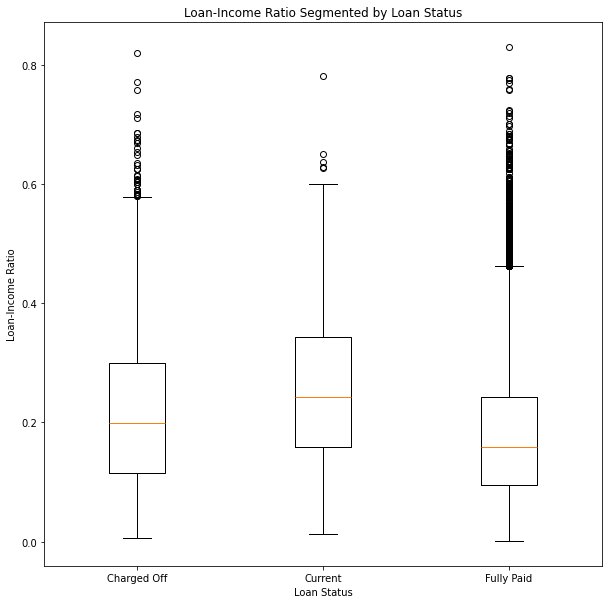

In [89]:
boxplt('loan_inc_ratio', 'Loan-Income Ratio')

The Fully Paid cohort has a lower median loan-income ratio than the Charged Off cohort. Even the third quartile is lower.

Next, we'll look at how long borrowers had credit when they applied for their loan.

In [90]:
df['credit_delta'] = df['issue_d']-df['earliest_cr_line']
df['credit_delta'] = df['credit_delta'].dt.days

In [91]:
df.groupby('loan_status')['credit_delta'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5627.0,4916.981695,2468.527485,1095.0,3287.0,4475.0,6058.0,17897.0
Current,1140.0,5886.366667,2574.387994,1125.0,4140.0,5493.0,7213.0,17227.0
Fully Paid,32950.0,5028.194780,2499.212149,1095.0,3318.0,4567.0,6210.0,23892.0


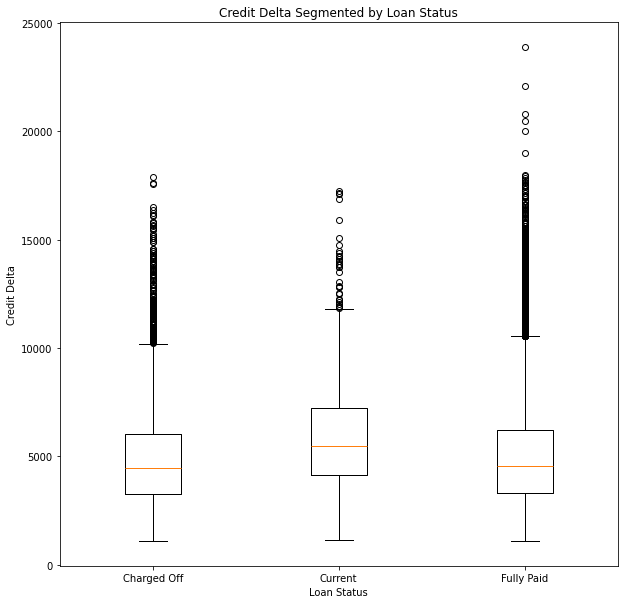

In [92]:
boxplt('credit_delta', 'Credit Delta')

The spread for all three cohorts are similar. While the median for Fully Paid is slightly higher than Charged Off, and Fully Paid has many of the highest values, because the figures overlap so much, we can't draw a firm conclusion here.

In [93]:
df['install_inc_ratio'] = df['installment']/(df['annual_inc']/12)

In [94]:
df.groupby('loan_status')['install_inc_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5627.0,0.073732,0.042959,0.001664,0.039982,0.066312,0.100520,0.297558
Current,1140.0,0.071832,0.037046,0.003141,0.043738,0.067026,0.095708,0.244694
Fully Paid,32950.0,0.064238,0.039371,0.000289,0.034264,0.056299,0.086171,0.320262


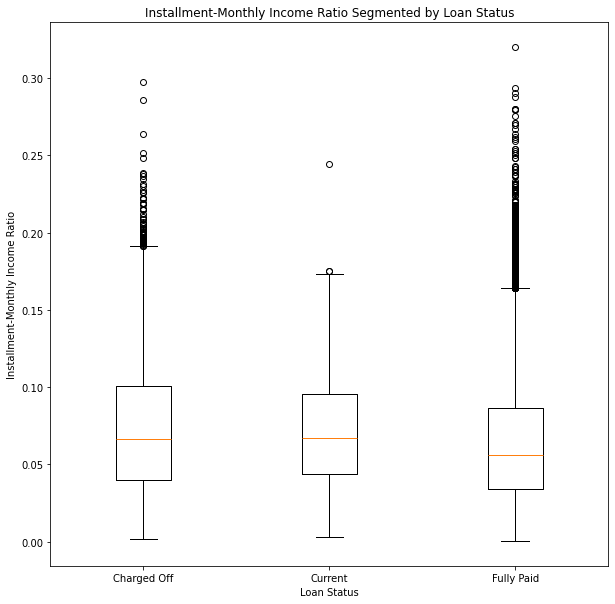

In [95]:
boxplt('install_inc_ratio', 'Installment-Monthly Income Ratio')

While Fully Paid has a lower median and quartile ratio than Charged Off, the difference isn't large enough to be significant.